In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

%matplotlib inline

use_cuda = torch.cuda.is_available()
if use_cuda:
    print('cuda available')
else:
    print('cuda unavailable')
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

cuda available


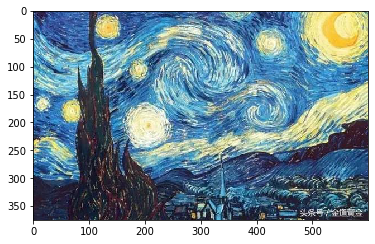

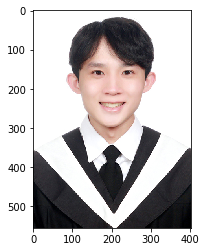

In [2]:
style_root = 'images/style.jpg'
content_root = 'images/content.jpg'

style_weight = 1000
content_weight = 1

imsize = 128

loader = transforms.Compose([
    transforms.ToTensor()
])

img_sizes = {}
def image_loader(image_root, image_title):
    image = Image.open(image_root)
    plt.imshow(image)
    plt.pause(0.001)
    
    img_sizes[image_title] = image.size
    image = image.resize((imsize , imsize))
    image = loader(image).clone().detach().requires_grad_(True)
    # 使用unsqueeze為image新增一個batch的維度
    image = image.unsqueeze(0)
    return image

plt.ion()
plt.figure()
style_img = image_loader(style_root, 'style_img').type(dtype)

plt.ion()
plt.figure()
content_img = image_loader(content_root, 'content_img').type(dtype)

assert style_img.size() == content_img.size() 

unloader = transforms.ToPILImage()

In [3]:
cnn = models.vgg19(pretrained = True).features
cnn = cnn.cuda() if use_cuda else cnn

class ContentLoss(nn.Module):
    def __init__(self, target, weight):
        super(ContentLoss, self).__init__()
         # 預設網路加權侍從target的直遷移過來的，所以使用detach來將他與原始圖片分離
        self.target = target.detach() * weight
        self.weight = weight
        self.criterion = nn.MSELoss()
        
    def forward(self, input):
        self.loss = self.criterion(input * self.weight, self.target)
        self.output = input
        return self.output

    def backward(self, retain_graph = True):
        self.loss.backward(retain_graph = retain_graph)
        return self.loss

class StyleLoss(nn.Module):
    def __init__(self, target, weight):
        super(StyleLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.criterion = nn.MSELoss()
        # self.gram = GramMatrix()
    
    def forward(self, input):
        self.output = input.clone()
        input = input.cuda() if use_cuda else input
        gram = Gram(input)
        gram.mul_(self.weight)
        self.loss = self.criterion(gram, self.target)
        return self.output
        
    def backward(self, retain_graph = True):
        self.loss.backward(retain_graph = retain_graph)
        return self.loss

def Gram(input):
    a, b, c, d = input.size()
    # a 為batch size = 1
    # b 為特徵圖數量
    #c, d為特徵圖尺寸

    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)

In [4]:
# 因為再vgg中第四曾conv出來的結果比較好 所以選用conv4當作與target比較的圖
content_layers = ['conv_4']

style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

content_losses = []
style_losses = []

model = nn.Sequential()
if use_cuda:
    model = model.cuda()
    
i = 1
for layer in list(cnn):
    if isinstance(layer, nn.Conv2d):
        name = 'conv_' + str(i)
        model.add_module(name, layer)
        
        if name in content_layers:
            target = model(content_img).clone()
            content_loss = ContentLoss(target, content_weight)
            content_loss = content_loss.cuda() if use_cuda else content_loss
            model.add_module('content_loss' + str(i), content_loss)
            content_losses.append(content_loss)
            
        if name in style_layers:
            target_feature = model(style_img).clone()
            target_feature = target_feature.cuda() if use_cuda else target_feature
            feature_gram = Gram(target_feature)
            style_loss = StyleLoss(feature_gram, style_weight)
            style_loss = style_loss.cuda() if use_cuda else style_loss
            model.add_module('style_loss_' + str(i), style_loss)
            style_losses.append(style_loss)
    
    if isinstance(layer, nn.ReLU):
        model.add_module('relu_' + str(i), layer)
        i += 1
        
    if isinstance(layer, nn.MaxPool2d):
        model.add_module('pool_' + str(i), layer)
print(model)

Sequential(
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_1): StyleLoss(
    (criterion): MSELoss()
  )
  (relu_1): ReLU(inplace=True)
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_2): StyleLoss(
    (criterion): MSELoss()
  )
  (relu_2): ReLU(inplace=True)
  (pool_3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_3): StyleLoss(
    (criterion): MSELoss()
  )
  (relu_3): ReLU(inplace=True)
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (content_loss4): ContentLoss(
    (criterion): MSELoss()
  )
  (style_loss_4): StyleLoss(
    (criterion): MSELoss()
  )
  (relu_4): ReLU(inplace=True)
  (pool_5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(

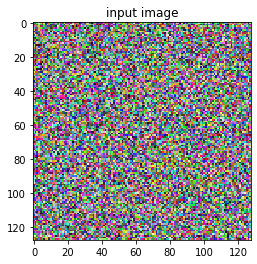

In [60]:
# 先創一張原圖用來當作最後的輸出圖
input_img = torch.randn(content_img.data.size())

if use_cuda:
    input_img = input_img.cuda()
    content_img = content_img.cuda()
    style_img = style_img.cuda()

plt.figure()
imshow(input_img.data, title = 'input image')

In [61]:
# 使用Input圖片當作網路參數，邊調節時邊讓他呈獻出result
input_param = nn.Parameter(input_img.data)
print(input_img.data.size())
optimizer = optim.LBFGS([input_param])
EPOCHS = 300

print("開始風格遷移")
for i in range(EPOCHS):
    input_param.data.clamp_(0, 1)
    
    model(input_param)
    style_score = 0
    content_score = 0
    
    optimizer.zero_grad()
    for sl in style_losses:
        style_score += sl.backward()
    for cl in content_losses:
        content_score += cl.backward()
    
    if i % 50 == 0:
        print('epoch : {}'.format(i))
        print('style_score : {:4f}, content_score : {:4f}'.format(
        style_score.data.item(), content_score.data.item()))
    
    def closure():
        return style_score + content_score
    
    optimizer.step(closure)

output = input_param.data.clamp_(0, 1)

torch.Size([1, 3, 128, 128])
開始風格遷移
epoch : 0
style_score : 33194.289062, content_score : 25.949024
epoch : 50
style_score : 5.632581, content_score : 9.584320
epoch : 100
style_score : 1.677577, content_score : 7.408737
epoch : 150
style_score : 1.172762, content_score : 6.031451
epoch : 200
style_score : 0.830615, content_score : 5.385909
epoch : 250
style_score : 0.678674, content_score : 4.995538


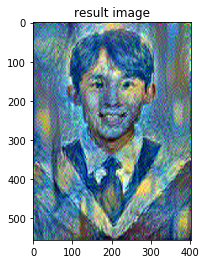

In [62]:
plt.figure()
result = output.clone().cpu()
result = result.view(3, imsize, imsize)
result = unloader(result)
result = result.resize(img_sizes['content_img'])
plt.imshow(result)
plt.title('result image')
plt.pause(0.001)

plt.ioff()
plt.show()